#### Actividad - Proyecto práctico


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Se recuerda que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1:
*   Alumno 2:
*   Alumno 3:
*   Alumno 4: 






### Entorno Acrobot-v1: dinámica, objetivo y criterio de éxito

**Descripción del entorno.** Acrobot es un sistema sub-actuado de dos eslabones con un único motor en la articulación central. El estado incluye senos y cosenos de los ángulos y sus velocidades angulares. El objetivo del agente es **elevar el extremo libre por encima de una altura umbral** (swing-up). [3]

**Recompensa.** En Acrobot-v1 la recompensa es $-1$ en cada paso mientras no se alcanza el objetivo, y $0$ cuando se logra. Por ello, maximizar la recompensa equivale a **minimizar el número de pasos** hasta el objetivo. El umbral de recompensa oficial es $-100$. [3]

**Finalización del episodio.** Un episodio termina cuando se alcanza la altura objetivo o cuando se llega al límite de pasos (500 pasos en v1). Por tanto, un episodio exitoso suele tener recompensa total mayor (menos negativa), e.g. $-100$ indica éxito en ~100 pasos, mientras que $-500$ indica no alcanzar la meta. [3]

**Criterio de la práctica.** La tarea exige **alcanzar el objetivo de altura durante 100 episodios de test consecutivos**. En esta implementación, el éxito se verifica cuando el episodio termina antes del límite de pasos.




### Objetivo geométrico (altura del extremo)

En **Acrobot-v1** el episodio termina con éxito cuando la **punta del segundo brazo** supera una **altura umbral** respecto al pivote.

En la implementación estándar (longitudes $l_1=l_2=1$), la altura del extremo libre se calcula como:

$\;h(θ_1,θ_2) = -\cos(θ_1) - \cos(θ_1 + θ_2)$

y el objetivo es **$h > 1.0$**. En otras palabras, la punta debe quedar **por encima de la línea horizontal** ubicada a una unidad de altura sobre el pivote. [3]


Altura h = 1.00 (éxito si h > 1.0)


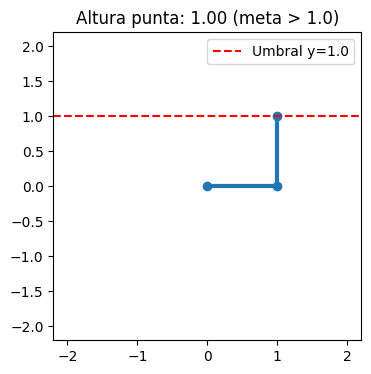

0.9999999999999999

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def tip_height(theta1, theta2, l1=1.0, l2=1.0):
    return -l1 * np.cos(theta1) - l2 * np.cos(theta1 + theta2)

def plot_acrobot(theta1, theta2, l1=1.0, l2=1.0, goal=1.0):
    # Posiciones de las articulaciones
    x0, y0 = 0.0, 0.0
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta1 + theta2)
    y2 = y1 - l2 * np.cos(theta1 + theta2)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot([x0, x1, x2], [y0, y1, y2], '-o', lw=3)
    ax.axhline(goal, color='red', linestyle='--', label=f'Umbral y={goal}')
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.2, 2.2)
    ax.set_title(f'Altura punta: {y2:.2f} (meta > {goal})')
    ax.legend()
    plt.show()
    return y2

# Ejemplo ilustrativo (ajusta θ_1, θ_2 si deseas)
theta1 = np.pi / 2  # 90°
theta2 = np.pi / 2  # 90°
h = tip_height(theta1, theta2)
print(f'Altura h = {h:.2f} (éxito si h > 1.0)')
plot_acrobot(theta1, theta2)


---
## **PARTE 1** - Entorno de trabajo con Docker (local)

En este proyecto se trabaja en un entorno **dockerizado** para asegurar reproducibilidad: misma versión de Python (3.8), mismas dependencias y mismo comportamiento en cualquier equipo. Además, el entrenamiento se ejecuta en **CPU** porque Acrobot es un entorno de **estado de baja dimensión** y el DQN utiliza una **MLP pequeña** (un par de capas densas) suficiente para aproximar $Q(s,a)$ en tareas de control clásico; en esta escala el coste computacional es bajo y no compensa la complejidad de GPU [1].

Para la visualización sin GUI se usa el modo `rgb_array` del entorno y generamos un MP4 a partir de los frames [1]. A continuación se describen los pasos para construir el entorno, ejecutar Jupyter Lab y entrenar/evaluar dentro del contenedor.


---
### 1.1. Construcción de la imagen Docker

La imagen se define en `docker/Dockerfile` y fija Python 3.8 junto con todas las dependencias del proyecto. Esto evita incompatibilidades entre equipos y permite repetir los resultados en cualquier máquina.

Se construye la imagen (solo la primera vez o cuando se cambien dependencias) utilizando el siguiente comando:
```bash
docker compose build
```


---
### 1.2. Jupyter Lab en Docker

El servicio `jupyter` del `docker-compose.yml` expone el puerto 8888 y monta el repositorio en `/workspace`.

Para poder renderizar y generar video sin entorno gráfico, se levanta un **display virtual** (Xvfb) y se definen las variables:
- `PYGLET_HEADLESS=1`: activa el modo headless de `pyglet` (no intenta abrir una ventana real).
- `SDL_VIDEODRIVER=dummy`: usa un backend de video falso para entornos sin pantalla.
- `DISPLAY=:99`: apunta al display virtual creado por Xvfb (el número 99 es el identificador del display).

El servicio se inicia así:
```bash
docker compose up jupyter
```

Se abre el navegador en:
```
http://localhost:8888/lab?token=TU_TOKEN
```
El token aparece en la salida del comando. Para detener el servicio, se usa `Ctrl+C`.

Si el HTML/Markdown (por ejemplo, videos) no se renderiza correctamente, marca el notebook como *Trusted* desde el contenedor:

```bash
docker compose exec jupyter jupyter trust /workspace/main.ipynb
```


---
### 1.3. Entrenamiento y evaluación (Docker)

El entrenamiento y la evaluación se ejecutan dentro del contenedor usando los scripts del proyecto. Se dispone de tres comandos principales:

El archivo `config.yaml` se usa para **modificar hiperparámetros directamente** (red, entrenamiento, exploración, etc.), lo que permite controlar y comparar mejoras del modelo desde un único punto de configuración.

**1) Entrenamiento**
```bash
./docker_train.sh configs/dqn_base.yaml dqn_base_01
```
- `configs/dqn_base.yaml`: archivo de configuración con hiperparámetros (entorno, red, training, etc.).
- `dqn_base_01`: identificador del run; se usa para nombrar carpetas y archivos de salida.

**2) Evaluación**
```bash
./docker_eval.sh outputs/runs/dqn_base_01/config.yaml outputs/weights/dqn_base_01_weights.h5 100 dqn_base_01
```
- `outputs/runs/dqn_base_01/config.yaml`: misma configuración usada en entrenamiento.
- `outputs/weights/dqn_base_01_weights.h5`: pesos del modelo entrenado.
- `100`: número de episodios de test.
- `dqn_base_01`: si se indica, guarda métricas y figuras en `outputs/runs/dqn_base_01/`.

**3) Entrenamiento + evaluación**
```bash
./docker_train_eval.sh configs/dqn_base.yaml dqn_base_01 100
```
- `configs/dqn_base.yaml`: configuración base.
- `dqn_base_01`: identificador del run.
- `100`: episodios de evaluación al terminar el entrenamiento.

Los resultados quedan en `outputs/runs/<run_id>/` (config, logs, métricas y figuras) y los pesos en `outputs/weights/`.


---
### 1.4. Estructura de directorios y clases

La organización del proyecto separa configuración, scripts, código y salidas de forma reproducible:

```text
08MIAR_PROYECTO/
├─ configs/                 # Configuración de experimentos (YAML)
├─ docker/                  # Dockerfile y documentación
├─ scripts/                 # Entrypoints CLI (train/eval)
├─ src/
│  └─ acrobot_dqn/           # Implementación principal DQN
│     ├─ agent.py            # Agente DQN y políticas
│     ├─ eval.py             # Evaluación
│     ├─ experiments.py      # Comparación y análisis de runs
│     ├─ model.py            # Arquitectura de red
│     ├─ plots.py            # Gráficas
│     ├─ render.py           # Video MP4 headless
│     ├─ trainer.py          # Entrenamiento
│     └─ utils.py            # Utilidades (config, seeds)
├─ outputs/                 # Runs, métricas, figuras, pesos
├─ books/                   # Bibliografía
└─ references/              # Referencias en IEEE
```

**Clases principales (DQN):**
- `DQNModelBuilder` (`src/acrobot_dqn/model.py`): construye la MLP para aproximar $Q(s,a)$.
- `DQNAgentFactory` (`src/acrobot_dqn/agent.py`): crea el agente DQN con replay buffer, política $ε$‑greedy y variantes.
- `DQNTrainer` (`src/acrobot_dqn/trainer.py`): ejecuta el entrenamiento, guarda logs, checkpoints y figuras.
- `DQNEvaluator` (`src/acrobot_dqn/eval.py`): evalúa en episodios de test y guarda métricas/gráficas.
- `EpisodeVideoRecorder` (`src/acrobot_dqn/render.py`): genera MP4 desde `rgb_array` en modo headless.
- `ExperimentComparator` (`src/acrobot_dqn/experiments.py`): carga runs ya entrenados, resume métricas/hiperparámetros y compara progreso entre experimentos.

**Módulos de soporte:**
- `plots.py`: utilidades para gráficas de entrenamiento y evaluación.
- `utils.py`: carga/guarda de configuración, semillas y gestión de directorios.

**Scripts (CLI):**
- `scripts/train.py`: entrena un run a partir de un `config.yaml`.
- `scripts/eval.py`: evalúa pesos entrenados y genera métricas/figuras.

Esta separación permite modificar hiperparámetros desde `configs/` sin tocar el código, y centraliza los resultados en `outputs/` para su análisis.


### Video de referencia (archivo local)

Algunos navegadores/Jupyter no renderizan bien el `<video>` en Markdown si el notebook no está marcado como *Trusted*. Por robustez, el video se muestra con una celda de código.


In [2]:
from pathlib import Path
from IPython.display import Video, display

video_ref = Path('outputs') / 'renders' / 'ejemplo_acrobot.mp4'
if video_ref.exists():
    display(Video(str(video_ref), embed=True))
else:
    print(f'No se encontro el video de referencia: {video_ref}')


---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que se trabajará será [Acrobot_V1](https://gymnasium.farama.org/environments/classic_control/acrobot/) y el algoritmo que se usará será _DQN_.

- Para este ejercicio, el requisito mínimo será **alcanzar el objetivo de altura durante 100 episodios de test consecutivos**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [3]:
import sys
from pathlib import Path
import json
import numpy as np
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, Video, HTML, display

ROOT = Path('.').resolve()
sys.path.append(str(ROOT / 'src'))

from acrobot_dqn.plots import plot_training_logs, plot_eval_results
from acrobot_dqn.utils import set_seeds
from acrobot_dqn.model import DQNModelBuilder
from acrobot_dqn.agent import DQNAgentFactory
from acrobot_dqn.render import EpisodeVideoRecorder
from acrobot_dqn.experiments import ExperimentComparator

import tensorflow as tf


2026-01-27 18:19:22.875171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-27 18:19:22.875209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Visualización del entorno (episodio aleatorio)

Para observar la dinámica del Acrobot sin GUI, se capturan frames con `rgb_array` y se codifican a MP4 [1].


In [4]:
ENV_NAME_RENDER = 'Acrobot-v1'
VIDEO_DIR = Path('outputs') / 'renders'
RANDOM_VIDEO = VIDEO_DIR / 'acrobot_random.mp4'

def random_policy(state, env):
    return env.action_space.sample()

recorder = EpisodeVideoRecorder(fps=30, max_steps=500)
random_video_path = recorder.record(
    ENV_NAME_RENDER,
    policy_fn=random_policy,
    out_path=RANDOM_VIDEO,
)
print(f'Video guardado en: {random_video_path}')
display(Video(str(random_video_path), embed=True))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x15fd3380] Warning: data is not aligned! This can lead to a speed loss


Video guardado en: outputs/renders/acrobot_random.mp4


#### Configuracion del run base (contexto del reporte)

Esta celda selecciona el `RUN_ID` que vas a documentar y carga su configuracion, rutas y logs para el resto de la PARTE 3.


In [5]:
# Run base que se reporta en la PARTE 3
RUN_ID = 'dqn_base_00'

RUN_DIR = Path('outputs') / 'runs' / RUN_ID
CONFIG_PATH = RUN_DIR / 'config.yaml'
EVAL_PATH = RUN_DIR / 'metrics' / 'eval.json'
FIG_DIR = RUN_DIR / 'figures'

if not CONFIG_PATH.exists():
    raise FileNotFoundError(f'No se encontro {CONFIG_PATH}. Asegura que el run existe.')

cfg = yaml.safe_load(CONFIG_PATH.read_text(encoding='utf-8'))
ENV_NAME = cfg.get('env_name', 'Acrobot-v1')
LOG_PATH = RUN_DIR / 'logs' / f'dqn_{ENV_NAME}_log.json'

def display_two_columns(df):
    mid = (len(df) + 1) // 2
    left = df.iloc[:mid]
    right = df.iloc[mid:]
    html = f'''
<div style="display:flex; gap:16px; align-items:flex-start;">
  <div style="flex:1;">{left.to_html()} </div>
  <div style="flex:1;">{right.to_html()} </div>
</div>
'''
    display(HTML(html))


In [6]:
SEED = int(cfg.get('seed', 123))
set_seeds(SEED)
print(f'Semilla global configurada: {SEED}')


Semilla global configurada: 123


1. Implementación de la red neuronal

La red para **Acrobot** no trabaja con píxeles, sino con el vector de estado continuo de 6 dimensiones. Por ello se utiliza una **MLP** sencilla que aproxima la función de valor de acción $Q_	heta(s,a)$, siguiendo la formulación de DQN [1]. En esta arquitectura, el estado se aplana y pasa por dos capas densas con activación ReLU; la salida produce un valor por acción discreta.

La elección de una MLP (en lugar de CNN) se justifica porque el espacio de observaciones no contiene estructura espacial, y el objetivo es aproximar $Q(s,a)$ de forma estable y eficiente [1], [2].


#### 1.1. Visualización del modelo implementado

A continuación se instancia la red **exactamente** desde las clases del proyecto (`DQNModelBuilder`) y se muestra su `summary()` para evidenciar la implementación real.


In [7]:
import gym

env_tmp = gym.make(ENV_NAME)
nb_actions = env_tmp.action_space.n
obs_shape = env_tmp.observation_space.shape
env_tmp.close()

model_builder = DQNModelBuilder(
    hidden_units=cfg.get('model', {}).get('hidden_units', [128, 128]),
    activation=cfg.get('model', {}).get('activation', 'relu'),
)
model = model_builder.build(obs_shape, nb_actions)

model.summary()

try:
    import tensorflow as tf
    from IPython.display import display
    display(tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True))
except Exception as e:
    print('plot_model no disponible en este entorno:', e)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17,795
Trainable params: 17,795
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

In [8]:
# Hiperparametros de la RED (no del agente completo)
import gym

env_tmp = gym.make(ENV_NAME)
nb_actions = env_tmp.action_space.n
obs_shape = env_tmp.observation_space.shape
env_tmp.close()

model_cfg = cfg.get('model', {})
model_params = {
    'model.hidden_units': model_cfg.get('hidden_units'),
    'model.activation': model_cfg.get('activation'),
    'observation_dim': int(np.prod(obs_shape)),
    'nb_actions': int(nb_actions),
}
# Convertimos valores potencialmente complejos (listas) a texto para mostrarlos en una sola columna.
model_params = {k: repr(v) for k, v in model_params.items()}
model_df = pd.DataFrame.from_dict(model_params, orient='index', columns=['value'])
display_two_columns(model_df)


,value
model.hidden_units,"[128, 128]"
model.activation,'relu'
,value
observation_dim,6
nb_actions,3


2. Implementación de la solución DQN

Se implementa DQN con: (i) **replay buffer** para romper correlaciones, (ii) política $\epsilon$-greedy con *annealing*, y (iii) *target network* opcionalmente actualizado cada cierto número de pasos, lo cual estabiliza el aprendizaje [1]. Las variantes **Double DQN** y **Dueling DQN** se activan con banderas, siguiendo las propuestas de estabilización y mejora del estimador de $Q$ descritas en [1].

La función objetivo se basa en el target de Bellman:

$$y(s,a)=r + \gamma \max_{a'} Q_{\theta^-}(s',a')$$

y la pérdida se minimiza típicamente con MSE o Huber:

$$\mathcal{L}(\theta)=\mathbb{E}\left[(y(s,a)-Q_{\theta}(s,a))^2\right].$$



#### 2.1. Instanciacion del agente DQN y sus hiperparametros

Primero se instancia el agente con `DQNAgentFactory(cfg)` para mostrar como la red se conecta con memoria, politica y variantes. Luego se listan los hiperparametros del agente con el mismo formato en dos columnas.


In [9]:
env_tmp = gym.make(ENV_NAME)
nb_actions = env_tmp.action_space.n
obs_shape = env_tmp.observation_space.shape
env_tmp.close()

model = DQNModelBuilder(
    hidden_units=cfg['model']['hidden_units'],
    activation=cfg['model']['activation'],
).build(obs_shape, nb_actions)

agent = DQNAgentFactory(cfg).build(model, nb_actions)

dqn_params = {
    'memory_limit': cfg.get('memory_limit'),
    'window_length': cfg.get('window_length'),
    'policy.eps_max': cfg.get('policy', {}).get('eps_max'),
    'policy.eps_min': cfg.get('policy', {}).get('eps_min'),
    'policy.eps_test': cfg.get('policy', {}).get('eps_test'),
    'policy.anneal_steps': cfg.get('policy', {}).get('anneal_steps'),
    'training.nb_steps': cfg.get('training', {}).get('nb_steps'),
    'training.warmup_steps': cfg.get('training', {}).get('warmup_steps'),
    'training.gamma': cfg.get('training', {}).get('gamma'),
    'training.learning_rate': cfg.get('training', {}).get('learning_rate'),
    'training.target_model_update': cfg.get('training', {}).get('target_model_update'),
    'variants.double_dqn': cfg.get('variants', {}).get('double_dqn'),
    'variants.dueling_dqn': cfg.get('variants', {}).get('dueling_dqn'),
    'variants.dueling_type': cfg.get('variants', {}).get('dueling_type'),
}
dqn_params = {k: repr(v) for k, v in dqn_params.items()}
dqn_df = pd.DataFrame.from_dict(dqn_params, orient='index', columns=['value'])
display_two_columns(dqn_df)


2026-01-27 18:20:33.355241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2026-01-27 18:20:33.355285: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2026-01-27 18:20:33.355325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e561200e34ca): /proc/driver/nvidia/version does not exist
2026-01-27 18:20:33.355745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,value
memory_limit,100000
window_length,1
policy.eps_max,1.0
policy.eps_min,0.05
policy.eps_test,0.02
policy.anneal_steps,50000
training.nb_steps,200000
,value
training.warmup_steps,1000
training.gamma,0.99


#### 2.3. Resultados del run base: entrenamiento

Estas graficas salen del log guardado durante el entrenamiento (`FileLogger`).


In [10]:
# Graficas de entrenamiento (se generan a partir del log)
if LOG_PATH.exists():
    plot_training_logs(LOG_PATH, FIG_DIR)
    img_a = FIG_DIR / 'training_reward.png'
    img_b = FIG_DIR / 'training_mean_q.png'
    if img_a.exists() and img_b.exists():
        html = f'''
<div style="display:flex; gap:16px;">
  <div style="flex:1;"><img src="{img_a.as_posix()}" style="width:100%;"></div>
  <div style="flex:1;"><img src="{img_b.as_posix()}" style="width:100%;"></div>
</div>
'''
        display(HTML(html))
    else:
        for img_path in [img_a, img_b]:
            if img_path.exists():
                display(Image(filename=str(img_path)))
else:
    print(f'No se encontro el log: {LOG_PATH}')


#### 2.4. Resultados del run base: evaluacion

Aqui se resumen metricas clave y se muestran las graficas de evaluacion.


In [11]:
# Cargar resultados de evaluación
if EVAL_PATH.exists():
    results = json.loads(EVAL_PATH.read_text(encoding='utf-8'))
    display(pd.DataFrame([{
        'successes': results.get('successes'),
        'success_rate': results.get('success_rate'),
        'mean_reward': results.get('mean_reward'),
    }]))
    plot_eval_results(results, FIG_DIR)
    img_a = FIG_DIR / 'eval_rewards.png'
    img_b = FIG_DIR / 'eval_rewards_hist.png'
    if img_a.exists() and img_b.exists():
        html = f'''
<div style="display:flex; gap:16px;">
  <div style="flex:1;"><img src="{img_a.as_posix()}" style="width:100%;"></div>
  <div style="flex:1;"><img src="{img_b.as_posix()}" style="width:100%;"></div>
</div>
'''
        display(HTML(html))
    else:
        for img_path in [img_a, img_b]:
            if img_path.exists():
                display(Image(filename=str(img_path)))
else:
    print(f'No se encontro el archivo: {EVAL_PATH}')
    


,successes,success_rate,mean_reward
0,100,1.0,-88.23


#### 2.5. Visualizacion de la politica entrenada (run base)

Se graba un episodio con el agente entrenado usando `rgb_array` y se guarda en MP4.


In [12]:
VIDEO_DIR = Path('outputs') / 'renders'
TRAINED_VIDEO = VIDEO_DIR / f'{RUN_ID}_policy.mp4'
WEIGHTS_PATH = Path('outputs') / 'weights' / f'{RUN_ID}_weights.h5'
ALT_WEIGHTS_PREFIX = Path('outputs') / 'weights' / f'{RUN_ID}_weights.h5f'
ALT_WEIGHTS_INDEX = Path(str(ALT_WEIGHTS_PREFIX) + '.index')

if not WEIGHTS_PATH.exists() and ALT_WEIGHTS_INDEX.exists():
    WEIGHTS_PATH = ALT_WEIGHTS_PREFIX

if not WEIGHTS_PATH.exists() and not ALT_WEIGHTS_INDEX.exists():
    print(f'No se encontro el archivo de pesos: {WEIGHTS_PATH}')
else:
    import gym
    tmp_env = gym.make(ENV_NAME)
    nb_actions = tmp_env.action_space.n
    obs_shape = tmp_env.observation_space.shape
    tmp_env.close()

    model = DQNModelBuilder(
        hidden_units=cfg.get('model', {}).get('hidden_units', [128, 128]),
        activation=cfg.get('model', {}).get('activation', 'relu'),
    ).build(obs_shape, nb_actions)
    agent = DQNAgentFactory(cfg).build(model, nb_actions)
    agent.load_weights(str(WEIGHTS_PATH))

    def dqn_policy(state, env):
        return agent.forward(state)

    def reset_agent():
        agent.reset_states()

    recorder = EpisodeVideoRecorder(fps=30, max_steps=500, seed=cfg.get('seed', 42))
    trained_video_path = recorder.record(
        ENV_NAME,
        policy_fn=dqn_policy,
        out_path=TRAINED_VIDEO,
        reset_fn=reset_agent,
    )
    print(f'Video guardado en: {trained_video_path}')
    display(Video(str(trained_video_path), embed=True))


/usr/local/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x3f422380] Warning: data is not aligned! This can lead to a speed loss


Video guardado en: outputs/renders/dqn_base_00_policy.mp4


3. Justificacion de los parametros seleccionados y de los resultados obtenidos

En esta seccion se justifica la arquitectura de la red, la construccion del agente DQN y la seleccion del conjunto inicial de hiperparametros. La idea es dejar claro que el run base no es arbitrario: es un punto de partida tecnico y defendible desde la teoria y la practica de DQN en control clasico [1], [2], y desde la naturaleza del entorno Acrobot [3].

#### 3.1. Justificacion del modelo de la red (MLP para Q(s,a))

Acrobot no entrega imagenes, sino un vector continuo de baja dimension (senos, cosenos y velocidades angulares). En este tipo de observaciones no hay estructura espacial que aprovechar con convoluciones, por lo que una MLP es la eleccion natural para aproximar $Q_\theta(s,a)$ [1], [2], [3]. Ademas, una red pequena (por ejemplo, dos capas densas) suele ser suficiente para capturar no linealidades relevantes sin introducir una capacidad excesiva que complique la estabilidad del entrenamiento en DQN [1].

La salida lineal con un valor por accion discreta implementa exactamente la formulacion de DQN: estimar valores de accion para seleccionar $\arg\max_a Q_\theta(s,a)$. Esta coherencia entre arquitectura y objetivo es una parte importante de la justificacion tecnica [1], [2].

#### 3.2. Justificacion de la solucion DQN (piezas de estabilidad)

DQN no es solo una red que aprende por TD: necesita mecanismos adicionales para evitar inestabilidades. El *replay buffer* reduce la correlacion temporal entre transiciones y mejora la calidad estadistica de los lotes de entrenamiento. La *target network* desacopla el objetivo de Bellman de la red online, reduciendo oscilaciones y divergencias por retroalimentacion rapida. Por ultimo, la exploracion $\epsilon$-greedy con *annealing* permite una fase inicial fuertemente exploratoria y una fase posterior mas explotadora. Estas tres piezas son, en la practica, el nucleo de por que DQN funciona de forma razonablemente estable [1], [2].

#### 3.3. Justificacion hiperparametro por hiperparametro (run base)

A continuacion, cada hiperparametro relevante se justifica de forma explicita, como un compromiso tecnico razonable para un run base.

**`model.hidden_units` (p. ej. [128, 128]).** En control clasico con estado de baja dimension, una MLP con dos capas densas moderadas suele ofrecer suficiente capacidad para aproximar funciones $Q$ no lineales sin hacer el ajuste demasiado delicado. Es un tamano comun como punto de partida antes de explorar redes mas grandes [1], [2].

**`model.activation` (ReLU).** ReLU es una eleccion estandar por su simplicidad, buen comportamiento numerico y capacidad para modelar no linealidades sin saturar como otras activaciones clasicas. En MLPs para DQN suele funcionar bien como baseline [1].

**`training.gamma = 0.99`.** El objetivo de Acrobot requiere planificacion a varios pasos (swing-up). Un descuento alto prioriza el retorno a largo plazo, lo cual es consistente con la naturaleza del problema y con recomendaciones habituales en DQN [1], [2], [3].

**`training.learning_rate = 1e-3` (Adam).** Un learning rate de $10^{-3}$ con Adam es un punto de partida habitual: no es extremadamente agresivo, pero tampoco tan pequeno que ralentice demasiado el aprendizaje inicial. Es razonable para un run base que luego se afinara en la seccion de mejoras [1].

**`training.target_model_update` (p. ej. 1000).** Actualizar el target cada cierto numero de pasos introduce inercia en el objetivo de Bellman. Valores del orden de miles de pasos suelen ser un buen compromiso entre estabilidad (targets mas lentos) y velocidad de adaptacion (targets no demasiado viejos) [1], [2].

**`memory_limit` (p. ej. 100000).** Un buffer amplio permite cubrir mas regiones del espacio de estados y reduce el riesgo de sobreajuste a experiencia muy reciente. Para entornos pequenos como Acrobot, este tamano es manejable y suficientemente rico para un baseline [1], [2].

**`training.warmup_steps` (p. ej. 1000).** Entrenar demasiado pronto puede sesgar las actualizaciones con experiencia muy pobre o poco diversa. Un warmup inicial permite llenar parcialmente la memoria antes de aprender, lo que mejora la estabilidad temprana [1], [2].

**Exploracion: `eps_max`, `eps_min`, `anneal_steps`, `eps_test`.** Comenzar con $\epsilon$ alto fuerza exploracion amplia cuando el agente aun no sabe nada. Reducirlo gradualmente mantiene exploracion suficiente pero permite consolidar una politica mas determinista. Separar un `eps_test` pequeno evita que la evaluacion subestime la politica por exceso de aleatoriedad [1], [2].

**`training.nb_steps`.** En DQN la cantidad de pasos totales controla cuanto tiempo tiene el agente para poblar el buffer, refinar el estimador y estabilizar el comportamiento. Un run base con un presupuesto amplio de pasos es coherente con el objetivo de llegar a 100/100 en test antes de comparar variantes [1], [2].

#### 3.4. Justificacion de como se leen y comparan los resultados

En Acrobot, la recompensa esta muy ligada al numero de pasos hasta el exito, y el criterio academico clave suele expresarse como porcentaje de episodios exitosos. Por eso es importante reportar conjuntamente `success_rate` y `mean_reward`, y mantener el mismo protocolo de evaluacion cuando se comparan mejoras. Cuando aparecen outliers negativos, la estrategia mas defendible es ajustar primero estabilidad (por ejemplo, learning rate y target update) y luego exploracion, documentando cada cambio y su efecto [1]--[3].



---
## **PARTE 4**. Experimentos y mejoras iterativas

En esta sección se propondrá un **modelo base** y luego se irán comparando mejoras de forma ordenada:

1) Se define un cambio concreto de hiperparámetros.
2) Se entrena con un nuevo `run_id`.
3) Se reportan métricas y figuras.
4) Se compara contra el base con el mismo criterio.


#### 4.1. Análisis del Run Base_00

#### a) Carga de Artefactos

Esta parte no entrena nada: solo lee lo que ya quedó guardado en `outputs/runs/<run_id>/` después de ejecutar los comandos Docker.


In [61]:
comparator = ExperimentComparator(output_dir='outputs')

BASE_RUN_ID = 'dqn_base_00'
base_art = comparator.load_run(BASE_RUN_ID)
base_cfg = base_art.cfg
base_metrics = base_art.metrics

base_art.run_dir.as_posix()


'outputs/runs/dqn_base_00'

#### b) Hiperparametros Totales

Se muestra la configuracion completa tal como se usó realmente al entrenar `dqn_base_00` (es decir, lo que quedó persistido en `config.yaml`).


In [62]:
base_cfg_df = pd.json_normalize(base_cfg, sep='.')
base_cfg_df = base_cfg_df.T.rename(columns={0: 'value'})
display_two_columns(base_cfg_df)


,value
env_name,Acrobot-v1
seed,123
window_length,1
memory_limit,100000
run_id,dqn_base_00
model.hidden_units,"[128, 128]"
model.activation,relu
policy.eps_max,1.0
policy.eps_min,0.05
policy.eps_test,0.02


#### c) Resultados Observados

Primero se resumen metricas clave y luego se visualizan las figuras ya generadas para el run base.


In [63]:
base_summary = pd.DataFrame([
    {
        'run_id': BASE_RUN_ID,
        'successes': base_metrics.get('successes'),
        'success_rate': base_metrics.get('success_rate'),
        'mean_reward': base_metrics.get('mean_reward'),
        'min_reward': min(base_metrics.get('rewards', []) or [None]),
        'max_reward': max(base_metrics.get('rewards', []) or [None]),
    }
])
base_summary


,run_id,successes,success_rate,mean_reward,min_reward,max_reward
0,dqn_base_00,100,1.0,-88.23,-204.0,-71.0


In [115]:
from IPython.display import HTML, display

def show_run_figures(run_id):
    imgs = [p for p in comparator.figure_paths(run_id) if p.exists()]
    if not imgs:
        print(f'No hay figuras para {run_id}')
        return
    html = '<div style="display:grid;grid-template-columns:1fr 1fr;gap:12px;">'
    for p in imgs:
        html += f'<div><img src="{p.as_posix()}" style="width:100%;"></div>'
    html += '</div>'
    display(HTML(html))

show_run_figures(BASE_RUN_ID)


#### d) Decision Tecnica para el Siguiente Experimento (base_01)

A partir de los resultados del `dqn_base_00`, se observa que el criterio de exito se cumple de forma consistente (`success_rate = 1.0`, 100/100). Sin embargo, la distribucion de recompensas muestra una cola negativa relevante: la recompensa media es aproximadamente `-88.23`, pero aparece un minimo cercano a `-204`, con varios episodios por debajo de `-120` y algunos por debajo de `-140`. Esto sugiere que, aunque la politica es buena en promedio, todavia presenta episodios ocasionales con trayectorias largas o ineficientes.

Bajo este diagnostico, la decision tecnica razonable no es aumentar capacidad (lo cual podria empeorar la estabilidad en DQN), sino priorizar la **estabilizacion del aprendizaje**. La literatura clasica de DQN recomienda, ante varianza alta u outliers, actuar primero sobre la agresividad de la actualizacion y sobre la velocidad a la que cambia el target: reducir ligeramente el `learning_rate` y hacer mas lenta la actualizacion de la red objetivo suele disminuir oscilaciones y sobreajuste a targets demasiado cambiantes [1], [2].

**Valores propuestos en base_01:**
- `training.learning_rate`: **0.0005** (desde 0.001)
- `training.target_model_update`: **5000** (desde 1000)

Por esa razon, para `dqn_base_01` se propuso mantener la arquitectura y el resto del protocolo, y modificar solo esos dos hiperparametros de estabilidad.


#### e) Comparacion Secuencial de Runs (base_00 vs base_01)

Una vez ejecutado `dqn_base_01`, la comparacion muestra que el cambio fue demasiado conservador: el `success_rate` cae a `0.04` (4/100) y la recompensa media desciende a aproximadamente `-488.72`. La distribucion se concentra cerca de `-500`, lo que indica que el agente casi no resuelve episodios. En consecuencia, la linea de cambios aplicada en `base_01` se considera **fallida** y no se adopta como base de mejora.

A continuacion se muestran la comparacion numerica y las graficas comparativas.


In [116]:
RUN_IDS = [
    'dqn_base_00',
    'dqn_base_01',
]
comparison_df = comparator.compare(RUN_IDS, sequential=True)
comparison_df


,run_id,success_rate,mean_reward,learning_rate,target_model_update,eps_min,anneal_steps,hidden_units,double_dqn,dueling_dqn,run_dir,delta_success_rate,delta_mean_reward
0,dqn_base_00,1.00,-88.23,0.0010,1000,0.05,50000,"[128, 128]",False,False,outputs/runs/dqn_base_00,NaN,NaN
1,dqn_base_01,0.04,-488.72,0.0005,5000,0.05,50000,"[128, 128]",False,False,outputs/runs/dqn_base_01,-0.96,-400.49


In [117]:
comp_paths = comparator.compare_eval_plots('dqn_base_00', 'dqn_base_01')
comp_imgs = [comp_paths['line'], comp_paths['hist']]
html = '<div style="display:grid;grid-template-columns:1fr 1fr;gap:12px;">'
for p in comp_imgs:
    html += f'<div><img src="{p.as_posix()}" style="width:100%;"></div>'
html += '</div>'
display(HTML(html))


#### 4.2. Análisis del Run Base_01

#### a) Carga de Artefactos


In [118]:
BASE01_RUN_ID = 'dqn_base_01'
base01_art = comparator.load_run(BASE01_RUN_ID)
base01_cfg = base01_art.cfg
base01_metrics = base01_art.metrics

base01_art.run_dir.as_posix()


'outputs/runs/dqn_base_01'

#### b) Hiperparametros Totales


In [119]:
base01_cfg_df = pd.json_normalize(base01_cfg, sep='.')
base01_cfg_df = base01_cfg_df.T.rename(columns={0: 'value'})
display_two_columns(base01_cfg_df)


,value
env_name,Acrobot-v1
seed,123
window_length,1
memory_limit,100000
run_id,dqn_base_01
model.hidden_units,"[128, 128]"
model.activation,relu
policy.eps_max,1.0
policy.eps_min,0.05
policy.eps_test,0.02


#### c) Resultados Observados


In [120]:
base01_summary = pd.DataFrame([
    {
        'run_id': BASE01_RUN_ID,
        'successes': base01_metrics.get('successes'),
        'success_rate': base01_metrics.get('success_rate'),
        'mean_reward': base01_metrics.get('mean_reward'),
        'min_reward': min(base01_metrics.get('rewards', []) or [None]),
        'max_reward': max(base01_metrics.get('rewards', []) or [None]),
    }
])
base01_summary


,run_id,successes,success_rate,mean_reward,min_reward,max_reward
0,dqn_base_01,4,0.04,-488.72,-500.0,-140.0


In [121]:
show_run_figures(BASE01_RUN_ID)


#### d) Comparacion con el run base (00)

Para mantener la misma estructura que en 4.1, se vuelve a mostrar la comparacion con el run base como referencia directa.


In [122]:
comp_paths = comparator.compare_eval_plots('dqn_base_00', 'dqn_base_01')
comp_imgs = [comp_paths['line'], comp_paths['hist']]
html = '<div style="display:grid;grid-template-columns:1fr 1fr;gap:12px;">'
for p in comp_imgs:
    html += f'<div><img src="{p.as_posix()}" style="width:100%;"></div>'
html += '</div>'
display(HTML(html))


#### e) Decision Tecnica para el Siguiente Experimento (base_02)

Dado que `dqn_base_01` degrado de forma severa el rendimiento, se decide **no** continuar desde esa linea de cambios. El siguiente experimento (`base_02`) se comparara directamente contra `base_00`, buscando una modificacion mas moderada que mejore estabilidad sin frenar el aprendizaje.

**Valores propuestos en base_02 (opcion 2):**
- `training.learning_rate`: **0.0007**
- `training.target_model_update`: **2000**


#### 4.3. Análisis del Run Base_02

#### a) Carga de Artefactos


In [123]:
BASE02_RUN_ID = 'dqn_base_02'
base02_art = comparator.load_run(BASE02_RUN_ID)
base02_cfg = base02_art.cfg
base02_metrics = base02_art.metrics

base02_art.run_dir.as_posix()


'outputs/runs/dqn_base_02'

#### b) Hiperparametros Totales


In [124]:
base02_cfg_df = pd.json_normalize(base02_cfg, sep='.')
base02_cfg_df = base02_cfg_df.T.rename(columns={0: 'value'})
display_two_columns(base02_cfg_df)


,value
env_name,Acrobot-v1
seed,123
window_length,1
memory_limit,100000
run_id,dqn_base_02
model.hidden_units,"[128, 128]"
model.activation,relu
policy.eps_max,1.0
policy.eps_min,0.05
policy.eps_test,0.02


#### c) Resultados Observados


In [125]:
base02_summary = pd.DataFrame([
    {
        'run_id': BASE02_RUN_ID,
        'successes': base02_metrics.get('successes'),
        'success_rate': base02_metrics.get('success_rate'),
        'mean_reward': base02_metrics.get('mean_reward'),
        'min_reward': min(base02_metrics.get('rewards', []) or [None]),
        'max_reward': max(base02_metrics.get('rewards', []) or [None]),
    }
])
base02_summary


,run_id,successes,success_rate,mean_reward,min_reward,max_reward
0,dqn_base_02,50,0.5,-295.85,-500.0,-69.0


In [126]:
show_run_figures(BASE02_RUN_ID)


#### d) Comparacion con el run base (00)

Se muestran las graficas comparativas entre `base_00` y `base_02` para evaluar si la modificacion moderada mejoro estabilidad o no.


In [127]:
comp_paths = comparator.compare_eval_plots('dqn_base_00', 'dqn_base_02')
comp_imgs = [comp_paths['line'], comp_paths['hist']]
html = '<div style="display:grid;grid-template-columns:1fr 1fr;gap:12px;">'
for p in comp_imgs:
    html += f'<div><img src="{p.as_posix()}" style="width:100%;"></div>'
html += '</div>'
display(HTML(html))


#### e) Decision Tecnica para el Siguiente Experimento (base_03)

Los resultados de `dqn_base_02` muestran una degradacion fuerte respecto a `base_00`: solo `50/100` exitos y una recompensa media cercana a `-295.85`. La mitad de los episodios cae en el maximo de pasos, lo que indica que el agente no logra completar el objetivo en un numero significativo de casos.

Dado este comportamiento, la siguiente propuesta es volver a un `learning_rate` mas cercano al base (0.001) y aumentar moderadamente el `target_model_update` (por ejemplo, 2000 o 3000), evitando reducir demasiado el ritmo de aprendizaje. Alternativamente, si la prioridad es reducir outliers sin tocar el learning rate, puede ajustarse la exploracion (`eps_min` y `anneal_steps`).

**Propuesta para base_03 (opcion conservadora):**
- `training.learning_rate`: **0.001**
- `training.target_model_update`: **2000**


#### 4.4. Análisis del Run Base_03

#### a) Carga de Artefactos


In [128]:
BASE03_RUN_ID = 'dqn_base_03'
base03_art = comparator.load_run(BASE03_RUN_ID)
base03_cfg = base03_art.cfg
base03_metrics = base03_art.metrics

base03_art.run_dir.as_posix()


'outputs/runs/dqn_base_03'

#### b) Hiperparametros Totales


In [129]:
base03_cfg_df = pd.json_normalize(base03_cfg, sep='.')
base03_cfg_df = base03_cfg_df.T.rename(columns={0: 'value'})
display_two_columns(base03_cfg_df)


,value
env_name,Acrobot-v1
seed,123
window_length,1
memory_limit,100000
run_id,dqn_base_03
model.hidden_units,"[128, 128]"
model.activation,relu
policy.eps_max,1.0
policy.eps_min,0.05
policy.eps_test,0.02


#### c) Resultados Observados


In [130]:
base03_summary = pd.DataFrame([
    {
        'run_id': BASE03_RUN_ID,
        'successes': base03_metrics.get('successes'),
        'success_rate': base03_metrics.get('success_rate'),
        'mean_reward': base03_metrics.get('mean_reward'),
        'min_reward': min(base03_metrics.get('rewards', []) or [None]),
        'max_reward': max(base03_metrics.get('rewards', []) or [None]),
    }
])
base03_summary


,run_id,successes,success_rate,mean_reward,min_reward,max_reward
0,dqn_base_03,41,0.41,-327.97,-500.0,-63.0


In [131]:
show_run_figures(BASE03_RUN_ID)

#### d) Comparacion con el run base (00)

Se comparan las curvas de evaluacion de `dqn_base_00` y `dqn_base_03` para observar cambios en estabilidad y outliers.


In [132]:
comp_paths = comparator.compare_eval_plots('dqn_base_00', 'dqn_base_03')
comp_imgs = [comp_paths['line'], comp_paths['hist']]
html = '<div style="display:grid;grid-template-columns:1fr 1fr;gap:12px;">'
for p in comp_imgs:
    html += f'<div><img src="{p.as_posix()}" style="width:100%;"></div>'
html += '</div>'
display(HTML(html))


#### e) Decision Tecnica para el Siguiente Experimento (base_04)

Los resultados de `dqn_base_03` siguen siendo inferiores al base: `success_rate = 0.41` (41/100) y `mean_reward ≈ -327.97`. La distribucion permanece muy sesgada hacia episodios largos, con una cantidad alta de recompensas en torno a `-500`. Esto indica que el ajuste no recupera la estabilidad ni el rendimiento del run base.

La siguiente propuesta es mantener `learning_rate` en el valor base y **modificar la exploracion** para facilitar que el agente encuentre trayectorias exitosas sin reducir el ritmo de aprendizaje. En particular, se propone reducir `eps_min` y extender `anneal_steps` para explorar mas tiempo antes de explotar.

**Propuesta para base_04 (exploracion controlada):**
- `policy.eps_min`: **0.01**
- `policy.anneal_steps`: **100000**


#### 4.5. Análisis del Run Base_04

#### a) Carga de Artefactos


In [133]:
BASE04_RUN_ID = 'dqn_base_04'
base04_art = comparator.load_run(BASE04_RUN_ID)
base04_cfg = base04_art.cfg
base04_metrics = base04_art.metrics

base04_art.run_dir.as_posix()


'outputs/runs/dqn_base_04'

#### b) Hiperparametros Totales


In [134]:
base04_cfg_df = pd.json_normalize(base04_cfg, sep='.')
base04_cfg_df = base04_cfg_df.T.rename(columns={0: 'value'})
display_two_columns(base04_cfg_df)


,value
env_name,Acrobot-v1
seed,123
window_length,1
memory_limit,100000
run_id,dqn_base_04
model.hidden_units,"[128, 128]"
model.activation,relu
policy.eps_max,1.0
policy.eps_min,0.01
policy.eps_test,0.02


#### c) Resultados Observados


In [135]:
base04_summary = pd.DataFrame([
    {
        'run_id': BASE04_RUN_ID,
        'successes': base04_metrics.get('successes'),
        'success_rate': base04_metrics.get('success_rate'),
        'mean_reward': base04_metrics.get('mean_reward'),
        'min_reward': min(base04_metrics.get('rewards', []) or [None]),
        'max_reward': max(base04_metrics.get('rewards', []) or [None]),
    }
])
base04_summary


,run_id,successes,success_rate,mean_reward,min_reward,max_reward
0,dqn_base_04,100,1.0,-75.39,-137.0,-62.0


In [136]:
show_run_figures(BASE04_RUN_ID)

#### d) Comparacion con el run base (00)

Se comparan las curvas de evaluacion de `dqn_base_00` y `dqn_base_04` para observar cambios en estabilidad y outliers.


In [137]:
comp_paths = comparator.compare_eval_plots('dqn_base_00', 'dqn_base_04')
comp_imgs = [comp_paths['line'], comp_paths['hist']]
html = '<div style="display:grid;grid-template-columns:1fr 1fr;gap:12px;">'
for p in comp_imgs:
    html += f'<div><img src="{p.as_posix()}" style="width:100%;"></div>'
html += '</div>'
display(HTML(html))


#### e) Decision Tecnica para el Siguiente Experimento (base_05)

Los resultados de `dqn_base_04` recuperan el 100% de exito y mejoran la recompensa media (`-75.39`), con un minimo alrededor de `-137`. Esto indica que la exploracion mas prolongada ayudó a evitar episodios fallidos y redujo la cola negativa.

Como el rendimiento ya es alto, el siguiente paso debe ser **conservador**: mantener la exploracion ajustada (`eps_min = 0.01`, `anneal_steps = 100000`) y probar una mejora leve de estabilidad para reducir aun mas los outliers sin perder el 100% de exito. En DQN, un ajuste razonable es aumentar moderadamente `target_model_update`, manteniendo el `learning_rate` base.

**Propuesta para base_05 (estabilidad suave):**
- `training.learning_rate`: **0.001** (sin cambios)
- `training.target_model_update`: **2000**
- `policy.eps_min`: **0.01** (mantener)
- `policy.anneal_steps`: **100000** (mantener)


#### 4.6. Análisis del Run Base_05

#### a) Carga de Artefactos


In [138]:
BASE05_RUN_ID = 'dqn_base_05'
base05_art = comparator.load_run(BASE05_RUN_ID)
base05_cfg = base05_art.cfg
base05_metrics = base05_art.metrics

base05_art.run_dir.as_posix()


'outputs/runs/dqn_base_05'

#### b) Hiperparametros Totales


In [139]:
base05_cfg_df = pd.json_normalize(base05_cfg, sep='.')
base05_cfg_df = base05_cfg_df.T.rename(columns={0: 'value'})
display_two_columns(base05_cfg_df)


,value
env_name,Acrobot-v1
seed,123
window_length,1
memory_limit,100000
run_id,dqn_base_05
model.hidden_units,"[128, 128]"
model.activation,relu
policy.eps_max,1.0
policy.eps_min,0.01
policy.eps_test,0.02


#### c) Resultados Observados


In [140]:
base05_summary = pd.DataFrame([
    {
        'run_id': BASE05_RUN_ID,
        'successes': base05_metrics.get('successes'),
        'success_rate': base05_metrics.get('success_rate'),
        'mean_reward': base05_metrics.get('mean_reward'),
        'min_reward': min(base05_metrics.get('rewards', []) or [None]),
        'max_reward': max(base05_metrics.get('rewards', []) or [None]),
    }
])
base05_summary


,run_id,successes,success_rate,mean_reward,min_reward,max_reward
0,dqn_base_05,90,0.9,-128.26,-500.0,-64.0


In [141]:
show_run_figures(BASE05_RUN_ID)


#### d) Comparacion con el run base (00)

Se comparan las curvas de evaluacion de `dqn_base_00` y `dqn_base_05` para verificar si la nueva configuracion mantiene el rendimiento del mejor run.


In [142]:
comp_paths = comparator.compare_eval_plots('dqn_base_04', 'dqn_base_05')
comp_imgs = [comp_paths['line'], comp_paths['hist']]
html = '<div style="display:grid;grid-template-columns:1fr 1fr;gap:12px;">'
for p in comp_imgs:
    html += f'<div><img src="{p.as_posix()}" style="width:100%;"></div>'
html += '</div>'
display(HTML(html))


#### e) Decision Tecnica para el Siguiente Experimento (fase de variantes)

`dqn_base_05` pierde rendimiento respecto al mejor run (`base_04`): baja a `success_rate = 0.90` y la recompensa media cae a aproximadamente `-128.26`, con una cola negativa notable (minimo `-500`). Esto indica que nuevas modificaciones de exploracion/estabilidad empiezan a deteriorar el aprendizaje en lugar de mejorarlo.

En este punto, la estrategia es **congelar los hiperparametros del mejor run (base_04)** y pasar a variantes del algoritmo. Se comienza con **Double DQN**, porque reduce la sobreestimacion de Q sin cambiar la arquitectura ni introducir mucha complejidad. El archivo de configuracion preparado es `configs/dqn_double.yaml` (mismos hiperparametros de `base_04`, con `double_dqn: true`).

La decision de pasar a **Dueling DQN** debe basarse en el resultado de Double: si Double no mejora o queda muy similar al base_04 mientras persisten outliers, tiene sentido explorar Dueling como alternativa arquitectonica. En cambio, si Double mejora de forma clara, Dueling se vuelve opcional. En entornos con pocas acciones como Acrobot, Dueling suele aportar beneficios limitados frente a Double, por lo que se prioriza Double como primer paso.


#### 4.7. Preparacion del siguiente experimento (variantes Double/Dueling)

El siguiente experimento se basara en los hiperparametros de `base_04`, activando primero **Double DQN**. Si no mejora, se intentara **Dueling DQN** con los mismos hiperparametros.


In [ ]:
def deep_get(d, *keys, default=None):
    cur = d
    for k in keys:
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur

proposed_variants = [
    {
        'run_id': 'dqn_base_06_double',
        'variants.double_dqn': True,
        'variants.dueling_dqn': False,
        'dueling_type': deep_get(base_cfg, 'variants', 'dueling_type'),
        'base_hparams': 'usar base_04',
    },
    {
        'run_id': 'dqn_base_07_dueling',
        'variants.double_dqn': False,
        'variants.dueling_dqn': True,
        'dueling_type': deep_get(base_cfg, 'variants', 'dueling_type') or 'avg',
        'base_hparams': 'usar base_04',
    },
]
pd.DataFrame(proposed_variants)


#### 4.x. Plantilla minima para cada experimento

- `config`: ...
- `run_id`: ...
- cambio respecto al anterior: ...
- resultados clave: `success_rate`, `mean_reward`, outliers.
- decision: ¿mejora o no mejora?


---

### **Referencias (IEEE)**

[1] A. Geron, *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*, 3rd ed., 2025, ch. 18.

[2] R. S. Sutton and A. G. Barto, *Reinforcement Learning: An Introduction*, 2nd ed., MIT Press, 2020.

[3] Farama Foundation, "Acrobot-v1," *Gymnasium Documentation*, 2025.